# Editing a scene

## Overview

In this tutorial, you will learn how to modify a Mitsuba scene after it has been loaded from a file. You might want to edit a scene before (re-)rendering it for many reasons. Maybe a corner is dim, or an object should be moved a bit to the left. Thankfully we can use the *traverse* mechanism to perform such modifications in Python with Mitsuba 3. As we will see in later tutorials, this mechanism is also essential for inverse rendering applications and more.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>List exposed parameters of Mitsuba objects</li>
  <li>Edit a scene and update its internal state accordingly</li>
</ul>

</div>

## Loading a scene

Following the same steps as in [Mitsuba quickstart tutorial][1], let's import `mitsuba`, set the desired variant and load a scene from an XML file on disk.

[1]: https://mitsuba.readthedocs.io/en/latest/src/quickstart/mitsuba_quickstart.html

In [96]:
import drjit as dr
import mitsuba as mi
mi.set_variant('llvm_ad_spectral')

scene = mi.load_file("../scenes/bunny_and_dragon.xml")

Let's quickly render this scene.

In [97]:
original_image = mi.render(scene, spp=128)

# Get the film
film = scene.sensors()[0].film()

# Convert to RGB automatically via bitmap() (which includes spectrum → RGB)
bitmap_rgb = film.bitmap(raw=False)
print(bitmap_rgb)

Bitmap[
  pixel_format = multichannel,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<40>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 nested.R; // @12, premultiplied alpha
    float32 nested.G; // @16, premultiplied alpha
    float32 nested.B; // @20, premultiplied alpha
    float32 nested.A; // @24, premultiplied alpha
    float32 albedo.X; // @28, premultiplied alpha
    float32 albedo.Y; // @32, premultiplied alpha
    float32 albedo.Z; // @36, premultiplied alpha
  ],
  data = [ 2.5 MiB of image data ]
]


/tmp/ipykernel_150672/3333182872.py:21: RuntimeWarning: invalid value encountered in power
  show(rgb ** (1/2.2), "Final Composited RGB")


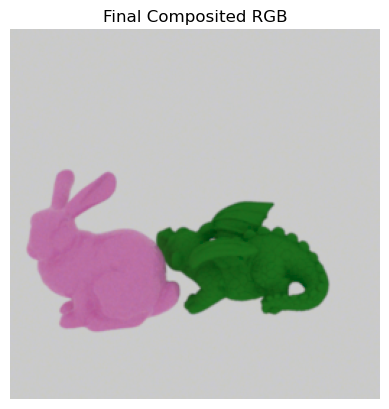

/tmp/ipykernel_150672/3333182872.py:22: RuntimeWarning: invalid value encountered in power
  show(nested_rgb ** (1/2.2), "Nested Path-Traced RGB")


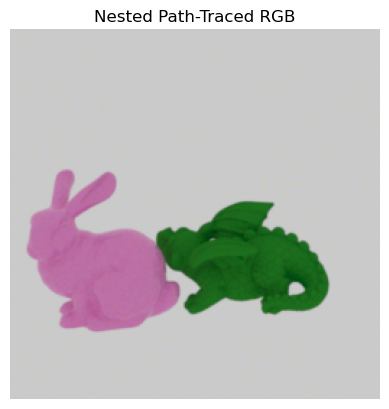

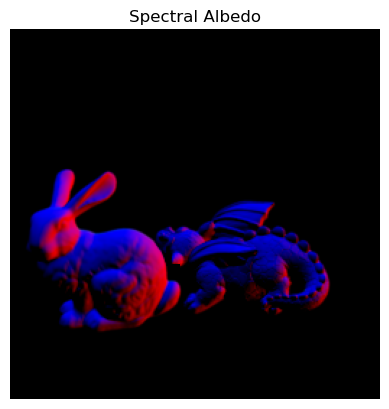

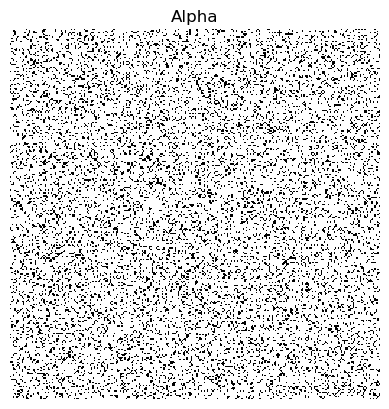

In [98]:
import numpy as np

# Convert bitmap to NumPy array
image = np.array(bitmap_rgb)

# Breakdown the elements in image
rgb        = image[..., 0:3]   # Main RGB
nested_rgb = image[..., 3:6]   # Path tracer RGB
alpha      = image[..., 6]     # Alpha channel
albedo     = image[..., 7:10]  # Spectral albedo

# Visualize
def show(img, title, cmap=None):
    plt.figure()
    plt.imshow(np.clip(img, 0, 1) if cmap is None else img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Gamma correct and show
show(rgb ** (1/2.2), "Final Composited RGB")
show(nested_rgb ** (1/2.2), "Nested Path-Traced RGB")
show(albedo, "Spectral Albedo")
show(alpha, "Alpha", cmap='gray')

## Accessing scene parameters

Any Mitsuba object can be inspected using the [<code>traverse()</code>][1] function, which returns a instance of [<code>SceneParameters</code>][2]. It has a similar API to Python `dict` and holds all parameters that are exposed by the input object and its children. Therefore, when given a scene as input, this function will return the parameters of all the objects present in the scene.

Let's print the paramters available in our teapot scene.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SceneParameters

In [99]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  ----------------------------------------------------------------------------------------------------
  Name                                             Flags    Type           Parent
  ----------------------------------------------------------------------------------------------------
  sensor.near_clip                                          float          PerspectiveCamera
  sensor.far_clip                                           float          PerspectiveCamera
  sensor.shutter_open                                       float          PerspectiveCamera
  sensor.shutter_open_time                                  float          PerspectiveCamera
  sensor.film.size                                          ScalarVector2u HDRFilm
  sensor.film.crop_size                                     ScalarVector2u HDRFilm
  sensor.film.crop_offset                                   ScalarPoint2u  HDRFilm
  sensor.x_fov                                     ∂, D     Float         

## AOVs
 Mistuba offers tutorials related to [<code>Arbitrary Output Variables integrator</code>][1]. The following function is defined for seperating different AOV and save them in corresponding .exr file.

[1]: https://mitsuba.readthedocs.io/en/stable/src/generated/plugins_integrators.html#arbitrary-output-variables-integrator-aov

In [161]:
def save_all_aovs(bitmap):
    """Save spectral albedo, RGB albedo, shading normal, depth, and position as separate EXR files."""
    channels = [field.name for field in bitmap.struct_()]
    res = dict(bitmap.split())

    # --- Save spectral albedo ---
    #albedo_spectral = res['albedo'] # albedo.X, albedo.Y, albedo.Z
    albedo_spectral = res['image'] # Test for exr file under rgb render
    albedo_spectral.write("results/albedo_spectral.exr")
    show(albedo_spectral, "Albedo")
    

    # Convert spectral albedo to RGB and save
    #albedo_rgb = mi.util.spectrum_to_rgb(albedo_spectral)
    #albedo_rgb.write("albedo_rgb.exr")

    # --- Save shading normal ---
    sh_normal = res['sh_normal']
    sh_normal.write("results/sh_normal.exr")
    show(sh_normal, "sh_normal")

    # --- Save depth ---
    depth = res['depth']
    depth.write("results/depth.exr")
    show(depth, "depth", cmap='gray')

    # --- Save position ---
    position = res['position']
    position.write("results/position.exr")
    show(position, "position")

### Function Test

Channels in bitmap: ['R', 'G', 'B', 'depth.T', 'image.R', 'image.G', 'image.B', 'image.A', 'position.X', 'position.Y', 'position.Z', 'sh_normal.X', 'sh_normal.Y', 'sh_normal.Z']


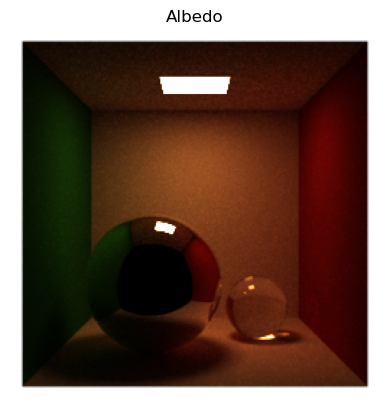

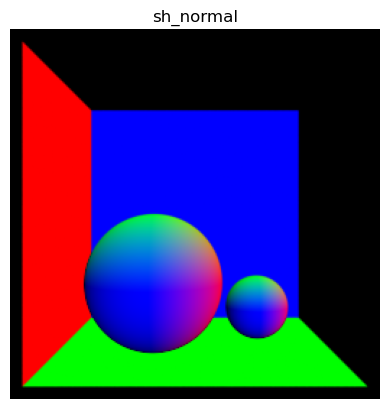

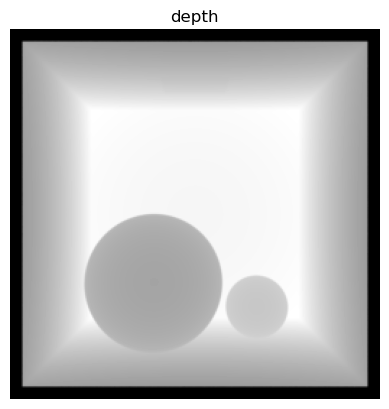

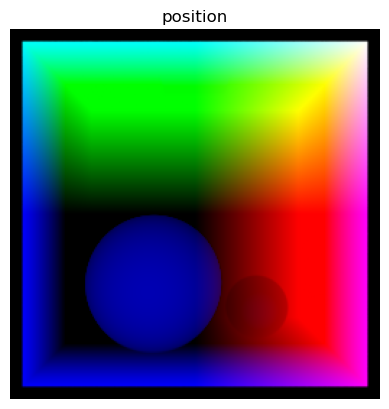

In [167]:
bitmap = mi.Bitmap('../scenes/textures/multi_channels.exr')

# Extract channel names
channel_names = [field.name for field in bitmap.struct_()]
print("Channels in bitmap:", channel_names)

save_all_aovs(bmp_exr)

### CONT'
Scene has only albedo AOV. Missing sh_normal, depth, and positon AOVs!!

In [ ]:
# Get the multi-channel bitmap (with AOVs)
bitmap = film.bitmap(raw=True)

# Extract channel names
channel_names = [field.name for field in bitmap.struct_()]
print("Channels in bitmap:", channel_names)

#save_all_aovs(bitmap)

Channels in bitmap: ['R', 'G', 'B', 'W', 'nested.R', 'nested.G', 'nested.B', 'nested.A', 'albedo.X', 'albedo.Y', 'albedo.Z']


## Edit the scene

Similarly to a Python `dict`, parameters can be modified in-place using the `__setitem__` operator. However, it is necessary to call the `SceneParameters.update` method to properly apply the desired changes.

Some objects need to be notified if the children have been updated. For instance, a change to the vertex position buffer of a mesh will trigger the recomputation of the Embree/Optix BHV.

Internally, the `SceneParameters` object will record every update written to it.
Using `SceneParameters.update` will propagate all updates through the dependency graph, and perform all necessary updates to the parent objects.

In [ ]:
# Give a red tint to light1 and a green tint to light2
params['light1.intensity.value'] *= [1.5, 0.2, 0.2]
params['light2.intensity.value'] *= [0.2, 1.5, 0.2]

# Apply updates
params.update();

Mesh editing is also possible but requires specifying the layout of the stored data. See [transformation toolbox][1] and [mesh manipulation][2] for more geometry and mesh operations.

[1]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/mesh_io_and_manipulation.html
[2]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/image_io_and_manipulation.html

In [ ]:
# Translate the bunny a little bit
V = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])
V.z += 0.5
params['bunny.vertex_positions'] = dr.ravel(V)

# Apply changes
params.update();

After rendering the scene again, we can easily compare the rendered images using `matplotlib`. 

In [ ]:
modified_image = mi.render(scene, spp=128)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1).imshow(original_image); plt.axis('off'); plt.title('original')
fig.add_subplot(1,2,2).imshow(modified_image); plt.axis('off'); plt.title('modified');

## See also

- [<code>mitsuba.traverse()</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse)
- [<code>mitsuba.SceneParameters</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html##mitsuba.SceneParameters)